<h1>
<center>Data Preprocessing </center>
</h1>

<font size="3">
This notebook is dedicated to data processing, whereby raw data is inputted and transformed into final dataframes. 
<br>
<br>
The process includes the following steps:
<li>Loading the raw data files as exported from the Bihance API.</li>
<li>Merging the necessary files to obtain a single dataframe that contains information for all cryptocurrencies.</li>
<li>Conducting feature engineering to create the necessary features.</li>
<li>Creating the target variable, which is the next close for each time step.</li>
<li>Dividing the data into train, validation, and test sets.</li>
<li>Saving the final dataframes for use in subsequent notebooks.</li>
</font>

## Generals 

<font size="3"> 
Packages import and system configurations. 
</font>

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import math

## Load dataset

<font size="3"> 
The aim of the bellow funciton is to load crypto coin data and concatenate with RSI, MACD, and MACD_RSI if specified.
<br>
<br>
The function performs the following steps:
<ol>
<li>Check if RSI, MACD, or MACD_RSI is specified.</li>
<li>If not specified, read the raw data of the coin.</li>
<li>If RSI or MACD is specified, read the raw data and the RSI or MACD data for the coin, concatenate the two dataframes, and drop the 'Time' column.</li>
<li>If MACD_RSI is specified, read the raw data, MACD data, and RSI data for the coin, concatenate the three dataframes, and drop the 'Time' column for MACD and RSI.</li>
<li>Drop any rows with null values.</li>
<li>Reset the index of the dataframe and drop the 'index' column.</li>
<li>Print the first five rows of the dataframe.</li>
<li>Return the concatenated dataframe.</li>
</ol> 
</font>

In [2]:
available_coins = ['ADA', 'BNB', 'BTC', 'DASH', 'ETH', 'LINK', 'LTC', 'XRP']
conc = None # "rsi", "macd", "macd_rsi"

def read_coin_data(coin_name: str, conc) -> pd.DataFrame:
    
    if conc == None:
        raw_data_path = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name ,f"{coin_name.lower()}_2019.csv")
        data_df = pd.read_csv(raw_data_path, index_col=False)
        return data_df
    
    elif (conc == "rsi") or (conc == "macd"):
        raw_data_path1 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name , f"{coin_name.lower()}_2019.csv")
        raw_data_path2 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name, f"{coin_name.lower()}_4h_{conc}.csv")

        data_df1 = pd.read_csv(raw_data_path1, index_col=False)
        data_df2 = pd.read_csv(raw_data_path2, index_col=False)
        data_df2 = data_df2.drop('Time', axis=1)
        data_df2 = data_df2.rename(columns={"0": conc})
        
        concatenated = pd.concat([data_df1, data_df2], axis="columns")

        
    elif conc == "macd_rsi":      
        raw_data_path1 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name , f"{coin_name.lower()}_2019.csv")
        raw_data_path2 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name, f"{coin_name.lower()}_4h_macd.csv")
        raw_data_path3 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name, f"{coin_name.lower()}_4h_rsi.csv")
        
        data_df1 = pd.read_csv(raw_data_path1, index_col=False)
        data_df2 = pd.read_csv(raw_data_path2, index_col=False)
        data_df3 = pd.read_csv(raw_data_path3, index_col=False)
        
        data_df2 = data_df2.drop('Time', axis=1)
        data_df2 = data_df2.rename(columns={"0": "macd"})
        
        data_df3 = data_df3.drop('Time', axis=1)
        data_df3 = data_df3.rename(columns={"0": "rsi"})

        concatenated = pd.concat([data_df1, data_df2, data_df3], axis="columns")

      
        
    concatenated = concatenated.dropna(axis=0)
    concatenated = concatenated.reset_index()
    concatenated = concatenated.drop('index', axis=1)
    print(concatenated.head())

    return concatenated


## Feature Engineering

### Time & date features

<font size="3"> 
The aim of the bellow funciton is to add date-related features to a DataFrame.
<br>
<br>
The function performs the following steps:
<ol>
<li>Converts the 'Date' column to datetime format.</li>
<li>Extracts and adds the year, month, day, week of year, and hour as new columns.</li>
<li>Returns the updated DataFrame.</li>
</ol> 
</font>

In [3]:
def append_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week
    df['Hour'] = df['Date'].dt.hour
    return df

<font size="3"> 
The aim of the bellow funciton is to create trigonometric columns for Year, Month, Day, and Hour. It converts the values.
<br>
<br>
The function performs the following steps:
<ol>
<li>Apply sine and cosine functions to Year, Month, Day, and Hour columns to create new columns.</li>
<li>Drop the original columns for Year, Month, Day, Week_of_Year, and Hour from the DataFrame.</li>
<li>Return the modified DataFrame.</li>
</ol> 
</font>

In [4]:
def create_trigonometric_columns(df) -> pd.DataFrame:
    # Create sine and cosine columns for Year, Month and Day
    df['Year_sin'] = df['Year'].apply(lambda x: math.sin(2*math.pi*x/2023))
    df['Year_cos'] = df['Year'].apply(lambda x: math.cos(2*math.pi*x/2023))
    df['Month_sin'] = df['Month'].apply(lambda x: math.sin(2*math.pi*x/12))
    df['Month_cos'] = df['Month'].apply(lambda x: math.cos(2*math.pi*x/12))
    df['Day_sin'] = df['Day'].apply(lambda x: math.sin(2*math.pi*x/31))
    df['Day_cos'] = df['Day'].apply(lambda x: math.cos(2*math.pi*x/31))
    df['Hour_sin'] = df['Hour'].apply(lambda x: math.sin(2*math.pi*x/24))
    df['Hour_cos'] = df['Hour'].apply(lambda x: math.cos(2*math.pi*x/24))
    df = df.drop(['Year'], axis=1)
    df = df.drop(['Month'], axis=1)
    df = df.drop(['Day'], axis=1)
    df = df.drop(['Week_of_Year'], axis=1)
    df = df.drop(['Hour'], axis=1)    
    return df

### Create target column

<font size="3"> 
The aim of the bellow funciton is to create a target variable by shifting the "Close" column forward by a specified number 
<br>
<br>
The function performs the following steps:
<ol>
<li>Define the target column and create a list of feature columns.</li>
<li>Create a new column for the shifted target variable and remove the last rows of the dataframe.</li>
<li>Return the modified DataFrame.</li>
</ol> 
</font>

In [5]:
def create_target_variable(df: pd.DataFrame, forecast_lead: int = 1) -> pd.DataFrame:    
    target_column = "Close"
    features = list(df.columns.difference([target_column]))
    
    target = f"{target_column}_lead_{forecast_lead}"
    df[target] = df[target_column].shift(-forecast_lead)
    df = df.iloc[:-forecast_lead]
    # display("Target added to dataframe", df.shape, df[['Close', target]].head())
    return df

<font size="3"> 
The aim of the bellow funciton is to create a  consolidated dataframe containing historical data of various cryptocurrencies with additional features and target variables for time series forecasting.
<br>
<br>
The function performs the following steps:
<ol>
<li>Create an empty dataframe with appropriate columns based on the concatenation parameter (if provided).</li>
<li>Loop through each cryptocurrency in the list and retrieve its historical data.</li>
<li>Process the data by appending date features, creating trigonometric columns, and generating a target variable.</li>
<li>Concatenate the processed data with the consolidated dataframe.</li>
<li>Perform one-hot encoding on the "Asset_id" column and drop unnecessary columns.</li>
</ol> 
</font>

In [6]:
def get_coins_data(coins: list, conc) -> pd.DataFrame:
    if conc == None:
        df = pd.DataFrame(columns=["Open", "High","Low", "Close", "Volume"])
    elif (conc == "rsi") or (conc == "macd"):
        df = pd.DataFrame(columns=["Open", "High","Low", "Close", "Volume", conc])
    elif conc == "macd_rsi":
        df = pd.DataFrame(columns=["Open", "High","Low", "Close", "Volume", "macd", "rsi"])
    
    for coin in coins:
        coin_df = read_coin_data(coin_name=coin, conc=conc)
        coin_df["Asset_id"] = coin
        coin_df = coin_df.rename(columns={"Time":"Date"})
        coin_df = append_date_features(df=coin_df)
        coin_df = create_trigonometric_columns(df=coin_df)
        coin_df = create_target_variable(df=coin_df, forecast_lead= 1)
        # Set date as index
        coin_df.set_index('Date', inplace=True)
        df = pd.concat([df, coin_df])
        
        
    one_hot = pd.get_dummies(df['Asset_id'])
    df = pd.concat([df, one_hot], axis=1)
    
    df['Target'] = df['Close_lead_1']
     
    df = df.drop(['Close_lead_1'], axis=1)
    display("Consolidated dataframe shape",df.shape)
    return df

In [7]:
consolidated_df = get_coins_data(coins=available_coins, conc=conc)
consolidated_df.head()

'Consolidated dataframe shape'

(63976, 23)

,Open,High,Low,Close,Volume,Asset_id,Year_sin,Year_cos,Month_sin,Month_cos,...,Hour_cos,ADA,BNB,BTC,DASH,ETH,LINK,LTC,XRP,Target
2019-07-20 16:00:00,0.06222,0.06509,0.06203,0.06474,35347035.0,ADA,-0.012423,0.999923,-0.5,-0.866025,...,-0.5,1,0,0,0,0,0,0,0,0.06262
2019-07-20 20:00:00,0.06475,0.06484,0.06221,0.06262,17106974.9,ADA,-0.012423,0.999923,-0.5,-0.866025,...,0.5,1,0,0,0,0,0,0,0,0.06147
2019-07-21 00:00:00,0.06262,0.064,0.06136,0.06147,15707034.1,ADA,-0.012423,0.999923,-0.5,-0.866025,...,1.0,1,0,0,0,0,0,0,0,0.06237
2019-07-21 04:00:00,0.06145,0.06253,0.06136,0.06237,7069070.1,ADA,-0.012423,0.999923,-0.5,-0.866025,...,0.5,1,0,0,0,0,0,0,0,0.06179
2019-07-21 08:00:00,0.0623,0.06315,0.06136,0.06179,10194081.5,ADA,-0.012423,0.999923,-0.5,-0.866025,...,-0.5,1,0,0,0,0,0,0,0,0.06048


## Split dataset (Train, Validarion, Test)

<font size="3"> 
The aim of the bellow funciton is to split a given DataFrame into training, validation, and testing sets based on specific dates.
<br>
<br>
The function performs the following steps:
<ol>
<li>Define two split dates for training, validation, and testing sets.</li>
<li>Filter the DataFrame based on the split dates to create three separate sets: train, valid, and test.</li>
<li>Print out the fractions and shapes of each set.</li>
<li>Return the three sets as separate DataFrames.</li>
</ol> 
</font>

In [8]:
def split_train_valid_test(data: pd.DataFrame):    
    # Split the data into training and testing sets
    split_date_1 = datetime(2022, 1, 1)
    split_date_2 = datetime(2022, 12, 1)
    train_data = data.loc[data.index < split_date_1]
    valid_data = data.loc[(split_date_1<= data.index) & (data.index <= split_date_2)]
    test_data = data.loc[data.index > split_date_2]
    
    print("Train set fraction:", round((len(train_data) / len(data)), 2),'%', "- train shape -> ", train_data.shape)
    print("Valid set fraction:", round((len(valid_data) / len(data)), 2),'%', "- valid shape -> ", valid_data.shape)
    print("Test set fraction:", round((len(test_data) / len(data)), 2),'%', "- test shape -> ", test_data.shape)
    return train_data, valid_data, test_data

In [9]:
train_data, valid_data, test_data = split_train_valid_test(data=consolidated_df)

Train set fraction: 0.67 % - train shape ->  (42960, 23)
Valid set fraction: 0.25 % - valid shape ->  (16040, 23)
Test set fraction: 0.08 % - test shape ->  (4976, 23)


### Save Final Datasets

In [10]:
output_path = join("io", "input", "base_data")
train_data.to_csv(join(output_path, "train.csv"))
valid_data.to_csv(join(output_path, "valid.csv"))
test_data.to_csv(join(output_path, "test.csv"))
print("Datasets saved!")

Datasets saved!


### Plot Time-Series

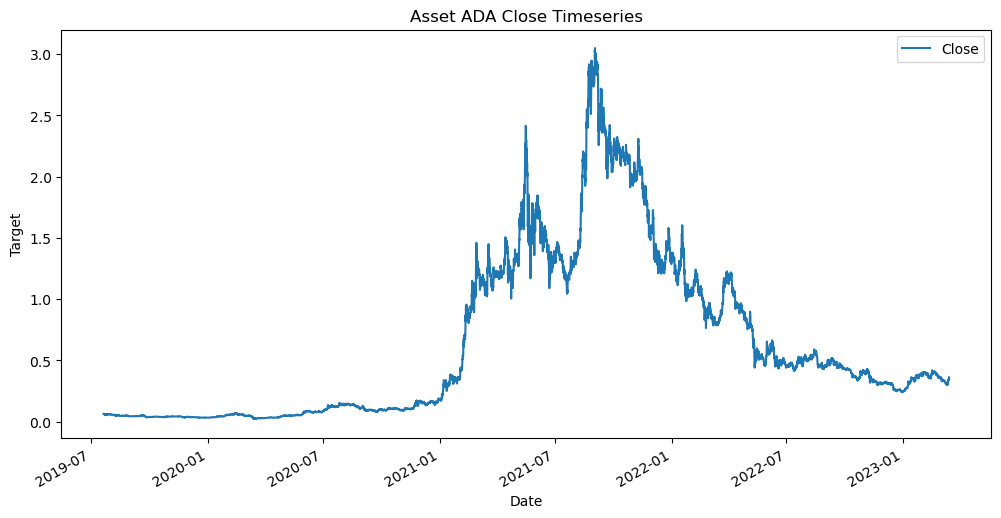

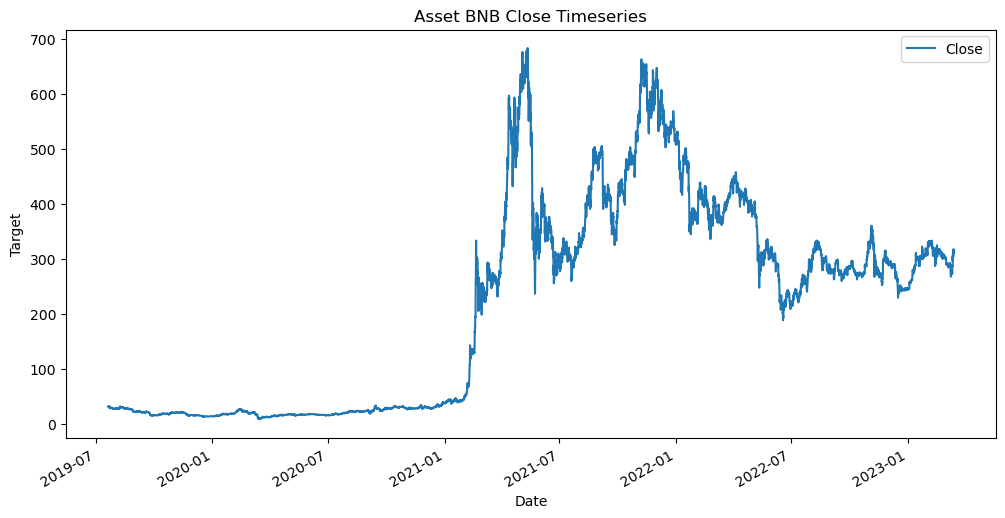

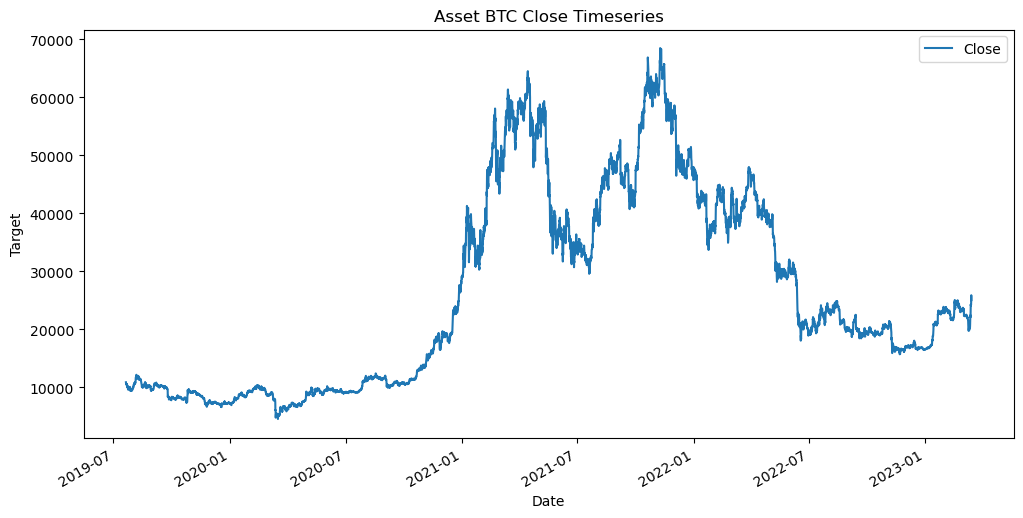

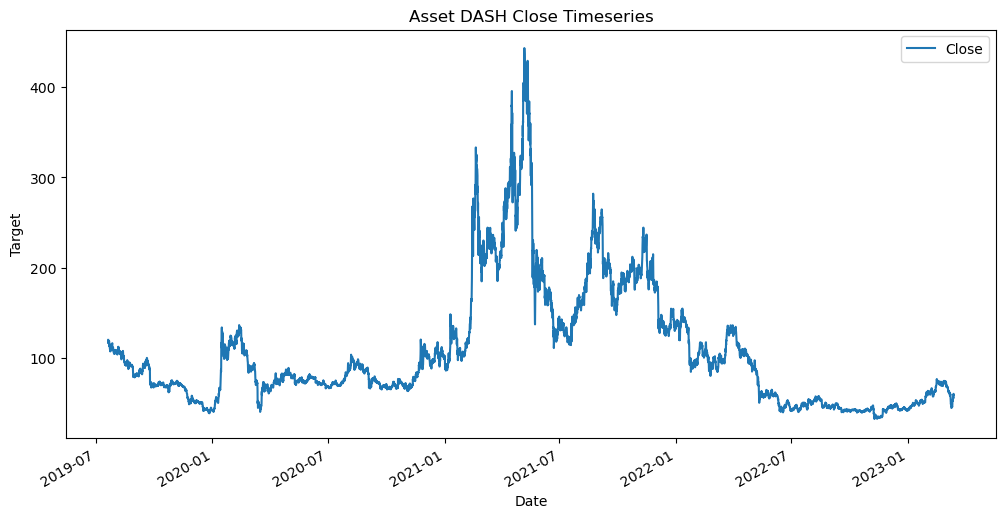

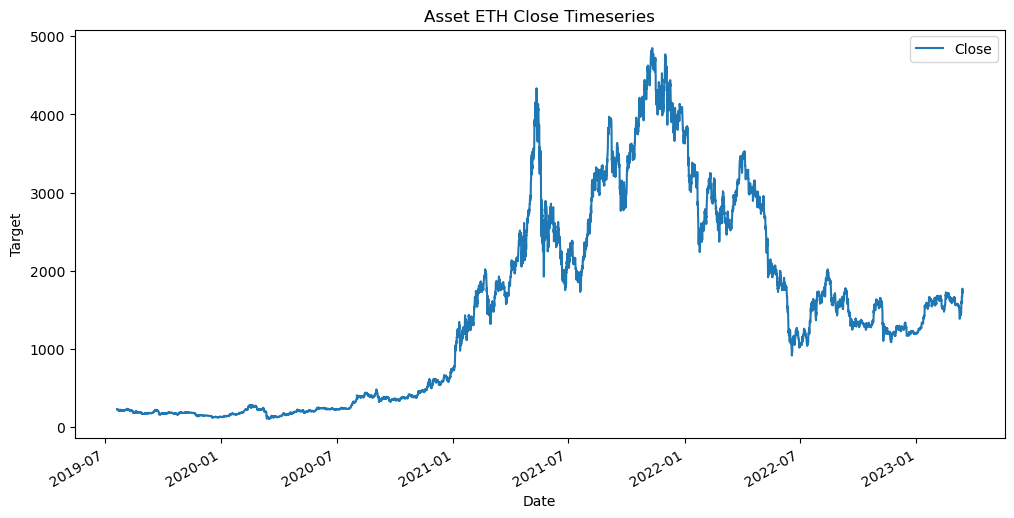

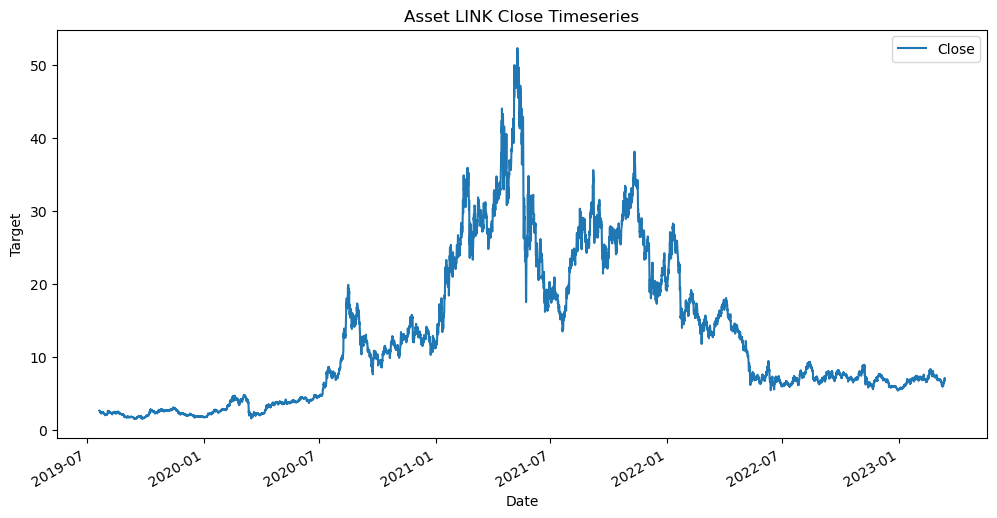

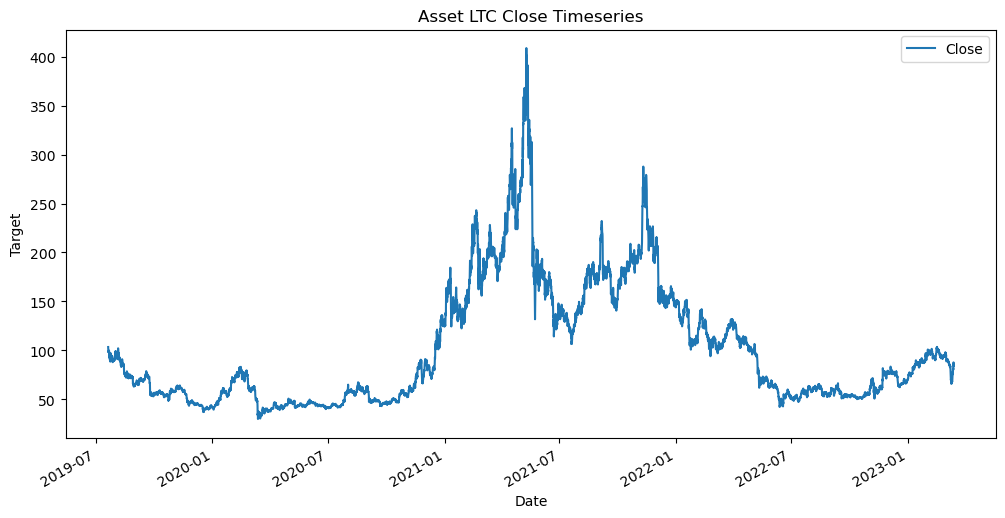

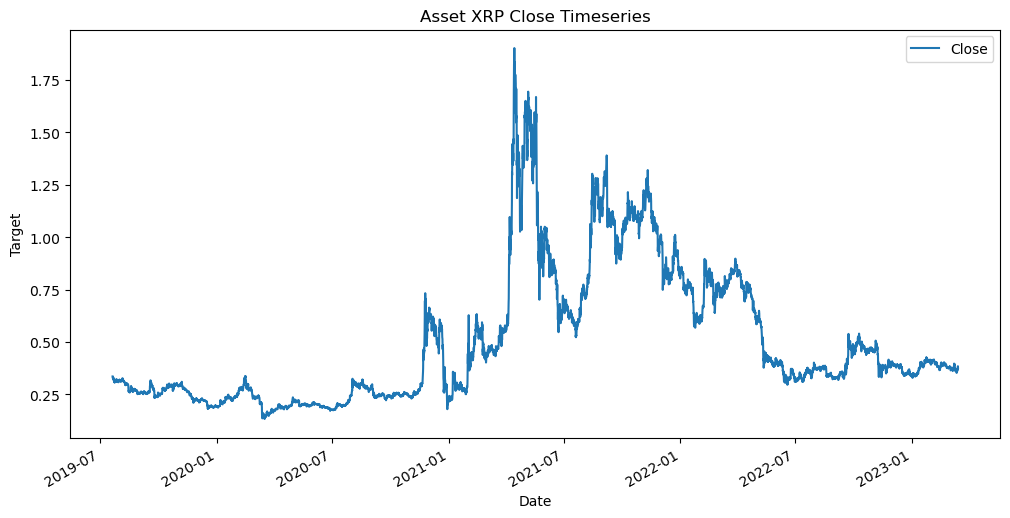

In [11]:
df=consolidated_df
import pandas as pd
import matplotlib.pyplot as plt

# assume your dataframe is called df and has columns 'Asset_id' and 'Close'
grouped = df.groupby('Asset_id')

for asset_id, group in grouped:
    # create a new figure for each plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # plot the timeseries for this asset_id
    group.plot(y='Close', ax=ax)
    
    # set title and axis labels
    ax.set_title(f"Asset {asset_id} Close Timeseries")
    ax.set_xlabel('Date')
    ax.set_ylabel('Target')
    
    # show the plot
    plt.show()